### <center>Capstone Project - Battle of Neighorhoods</center>

#### The aim of this project is to find the best location in the city of Toronto for opening an Indian restaurent. I will scrape the Wikipage to get the various location of Toronto and then using Foursquare location details, I will get the list of restaurents in the various areas in Toronto. The aim is to find a location where there is a minimum number of Indian restaurent.

In [1]:
import random # library for random number generation
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
import requests

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported...')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  35.07 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  23.83 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  34.10 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  39.57 MB/s
Libraries imported...


In [2]:
import os
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Scraping the data from Wikipedia and storing in the dataframe in the required formar

In [4]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

df_postcode=pd.read_html(url, header=0)[0]

df_postcode.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [5]:
#Renaming the column 'PostCode' into 'PostalCode'
df_postcode.rename(index=str, columns={"Postcode": "PostalCode"}, inplace=True )
df_postcode.head()

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Cleaning the data

There are some Borough which are 'Not assigned'. I will ignore those rows.

In [6]:
#Deleting rows with Boroughs as 'Not assigned'
df_postcode = df_postcode[df_postcode.Borough != 'Not assigned'].reset_index()
df_postcode.head()

,index,PostalCode,Borough,Neighbourhood
0,2,M3A,North York,Parkwoods
1,3,M4A,North York,Victoria Village
2,4,M5A,Downtown Toronto,Harbourfront
3,5,M5A,Downtown Toronto,Regent Park
4,6,M6A,North York,Lawrence Heights


There are  some rows with same Postal Code, I will combine those rows and will combine the Neighbourhoods for those rows

In [7]:
foo = lambda a: ",".join(a) 
df=df_postcode.groupby(['PostalCode','Borough']).agg({'Neighbourhood': foo}).reset_index()

In [8]:
df.head()

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


There is a neighbourhood as 'Not Assigned', I will update that with the valjue of it Borough

In [9]:
df.loc[df.Neighbourhood=='Not assigned','Neighbourhood']=df.loc[df.Neighbourhood=='Not assigned','Borough']
df

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park"
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge"
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


  I am using the csv file located at https://cocl.us/Geospatial_data to fetch the Geopatial data and storing into a dataframe

In [10]:
data = pd.read_csv("https://cocl.us/Geospatial_data") 
data

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


Updating the column 'Postal Code' to 'PostalCode' in the 'data' dataset to match the column name in the location dataframe df and then joining the two datasets.

In [13]:
data.rename(columns={"Postal Code": "PostalCode"}, inplace=True )
#Joining the two datasets
df_loc = pd.merge(df, data, on='PostalCode', how='left')
df_loc

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


In [12]:
df_loc.shape

(103, 5)

There are total 103 different Postal areas in Toronto

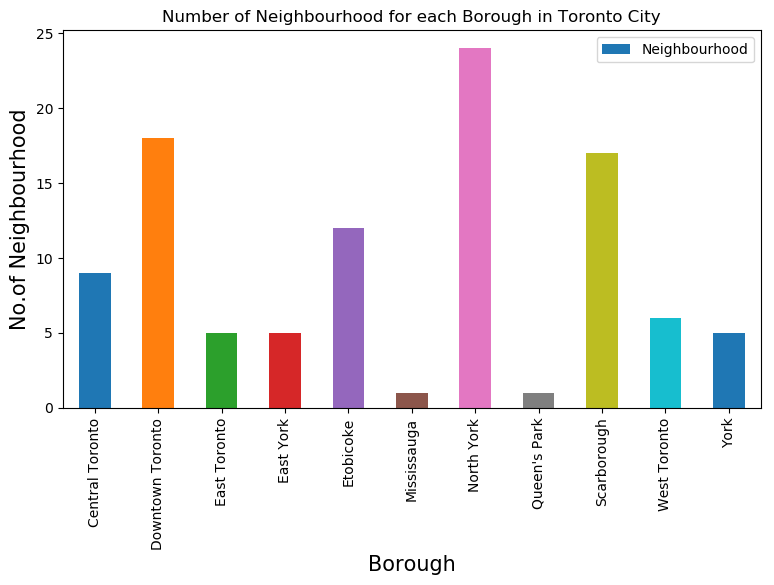

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighbourhood for each Borough in Toronto City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighbourhood', fontsize=15)
#giving a bar plot
df_loc.groupby('Borough')['Neighbourhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From the above plot we see that 'North York' Borough has the maximum number of neighbourhoods

I will utilizethe FoursquareAPI to explore the neighborhoods and fetch the details of the restaurents.

In [67]:
CLIENT_ID = 'ZEATRNFWCJS5FEUWHRJP4F0SYY5BISGYHMBLQEHQQAR5O22D' # your Foursquare ID
CLIENT_SECRET = 'Z14OJ1LPCJSBCYTQL5ZTFLPVU2MDHSXIJRXGYT3B5XJGT5KL' # your Foursquare Secret
VERSION = '20180605'

Defining a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return the venue id , venue name and category.

In [68]:
def get_venues(lat,lng):
    
    #setting variables
    radius=1000
    LIMIT=100
    
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Defining a function to get venue details like like count , rating , tip counts for a given venue id.

In [69]:
def get_venue_details(venue_id):
        
    #CLIENT_ID = 'RTNI2ES4HYZGIXUAD4F5VALRVBKLRESZHRJHKUUZ2J4ZHLMJ' # your Foursquare ID
    #CLIENT_SECRET = '2CJHFX1G1K0TJSSHXRD2RBVZ2ZNZQXH4FU4BRKLRCRYFJO4Z' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Collecting the details of Indian restaurent for each neighbourhood

In [70]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighbourhood', 'ID','Name']
indian_rest_toronto=pd.DataFrame(columns=column_names)
count=1
for row in df_loc.values.tolist():
    PostalCode, Borough, Neighbourhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(df_loc),')','Indian Resturants in '+Neighbourhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_toronto = indian_rest_toronto.append({'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Indian Resturants in Rouge,Malvern, Scarborough:0
( 2 / 103 ) Indian Resturants in Highland Creek,Rouge Hill,Port Union, Scarborough:0
( 3 / 103 ) Indian Resturants in Guildwood,Morningside,West Hill, Scarborough:0
( 4 / 103 ) Indian Resturants in Woburn, Scarborough:1
( 5 / 103 ) Indian Resturants in Cedarbrae, Scarborough:2
( 6 / 103 ) Indian Resturants in Scarborough Village, Scarborough:0
( 7 / 103 ) Indian Resturants in East Birchmount Park,Ionview,Kennedy Park, Scarborough:0
( 8 / 103 ) Indian Resturants in Clairlea,Golden Mile,Oakridge, Scarborough:0
( 9 / 103 ) Indian Resturants in Cliffcrest,Cliffside,Scarborough Village West, Scarborough:0
( 10 / 103 ) Indian Resturants in Birch Cliff,Cliffside West, Scarborough:0
( 11 / 103 ) Indian Resturants in Dorset Park,Scarborough Town Centre,Wexford Heights, Scarborough:2
( 12 / 103 ) Indian Resturants in Maryvale,Wexford, Scarborough:1
( 13 / 103 ) Indian Resturants in Agincourt, Scarborough:1
( 14 / 103 ) Indian Resturan

In [71]:
indian_rest_toronto.head()

,Borough,Neighbourhood,ID,Name
0,Scarborough,Woburn,4c632edeedd320a19ad5ae29,Bombay Palace
1,Scarborough,Cedarbrae,4d6008f829ef236a8832a059,CANBE Foods Inc
2,Scarborough,Cedarbrae,4c77fc87bd346dcb8c90f0ef,La Sani Grill
3,Scarborough,"Dorset Park,Scarborough Town Centre,Wexford He...",5226562611d2cd49d83ef03b,Kairali
4,Scarborough,"Dorset Park,Scarborough Town Centre,Wexford He...",4bf96c435317a593a23a017f,Karaikudi Chettinad South Indian Restaurant


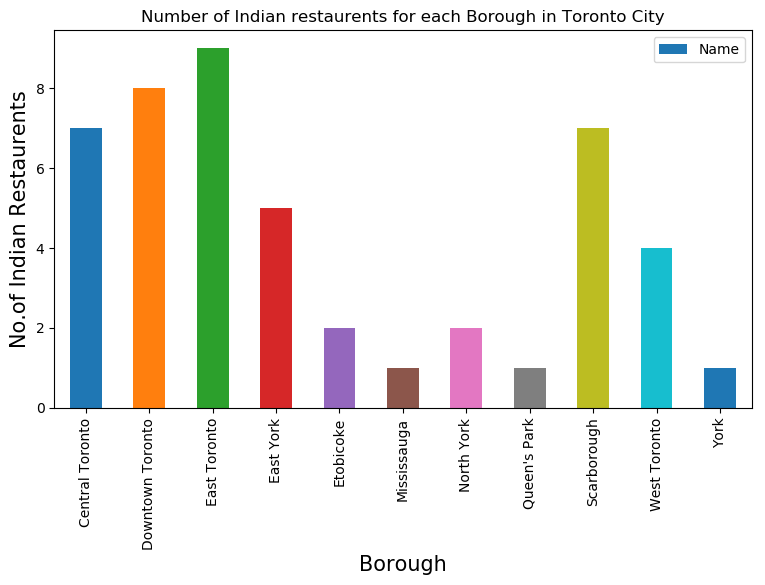

In [72]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian restaurents for each Borough in Toronto City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurents', fontsize=15)
#giving a bar plot
indian_rest_toronto.groupby('Borough')['Name'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From above plot we see that Mississauga, Queen's Park and York has the minimum number of Indian restaurents.

In [73]:
indian_rest_borough_min2 = indian_rest_toronto[indian_rest_toronto['Borough'].isin(['Mississauga','Queen\'s Park','York'])]

In [74]:
indian_rest_borough_min2

,Borough,Neighbourhood,ID,Name
40,York,"The Junction North,Runnymede",4b3bd657f964a520377c25e3,Roti Time
43,Queen's Park,Queen's Park,4bedf8b5e24d20a17b567214,Kothur Indian Cuisine
44,Mississauga,Canada Post Gateway Processing Centre,4bff0c5668c7a5932a1f4044,Zauq


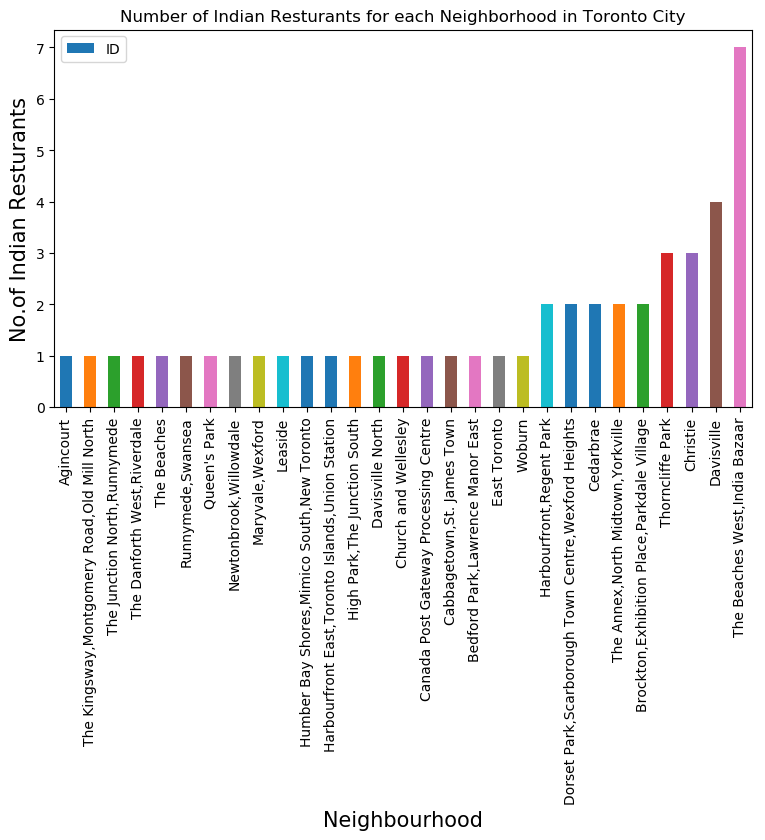

In [75]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in Toronto City')
#On x-axis
plt.xlabel('Neighbourhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_toronto.groupby('Neighbourhood')['ID'].count().nsmallest(30).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From above plot we can see that there are around 20 Neighbourhoods which has the lowest number of Indian Restaurents. Lets fetch the Neighbourhood details which has the lowest number of Indian restaurents.

In [76]:
indian_rest_toronto.groupby('Neighbourhood')['ID'].count().nsmallest(30)

Neighbourhood
Agincourt                                              1
The Kingsway,Montgomery Road,Old Mill North            1
The Junction North,Runnymede                           1
The Danforth West,Riverdale                            1
The Beaches                                            1
Runnymede,Swansea                                      1
Queen's Park                                           1
Newtonbrook,Willowdale                                 1
Maryvale,Wexford                                       1
Leaside                                                1
Humber Bay Shores,Mimico South,New Toronto             1
Harbourfront East,Toronto Islands,Union Station        1
High Park,The Junction South                           1
Davisville North                                       1
Church and Wellesley                                   1
Canada Post Gateway Processing Centre                  1
Cabbagetown,St. James Town                             1
Bedford Park,Lawr

Lets create a dataframe which has the neighbourhoods with lowest number of Indian restaurents.

In [66]:
indian_rest_nei_min1=indian_rest_toronto[indian_rest_toronto['Neighbourhood'].isin(['Agincourt',	'The Kingsway,Montgomery Road,Old Mill North',	'The Junction North,Runnymede',	'The Danforth West,Riverdale',	'The Beaches',	'Runnymede,Swansea',	'Queen\'s Park',	'Newtonbrook,Willowdale',	'Maryvale,Wexford',	'Leaside',	'Humber Bay Shores,Mimico South,New Toronto',	'Harbourfront East,Toronto Islands,Union Station',	'High Park,The Junction South',	'Davisville North',	'Church and Wellesley',	'Canada Post Gateway Processing Centre',	'Cabbagetown,St. James Town',	'Bedford Park,Lawrence Manor East',	'East Toronto',	'Woburn'])]
indian_rest_nei_min1

,Borough,Neighbourhood,ID,Name
0,Scarborough,Woburn,4c632edeedd320a19ad5ae29,Bombay Palace
5,Scarborough,"Maryvale,Wexford",4c27cddd9fb5d13a8cab9857,Patna Kebab House
6,Scarborough,Agincourt,4d570727fb65236a7f600db4,Silver Spoon Pak-Indian Restaurant
7,North York,"Newtonbrook,Willowdale",4b43dde2f964a52099ec25e3,Earth Indian Restaurant
8,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro
9,East York,Leaside,504bcf32e4b0ef19b0e2ecf8,Mt Everest Restaurant
13,East York,East Toronto,4c9fe5ca03133704df8d76d5,Raj Kapuri Paan & Snacks
14,East Toronto,"The Danforth West,Riverdale",4c1d5337eac020a1cb1048c2,Sher-E-Punjab
22,Central Toronto,Davisville North,4b7ccc72f964a520e3a52fe3,Banjara Indian Cuisine
27,Downtown Toronto,"Cabbagetown,St. James Town",4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory


Lets get the Ranking, Likes and Tips of each resturant for further analysis

In [77]:
# prepare neighbourhood list that contains indian resturants
column_names=['Borough', 'Neighbourhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_toronto=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_nei_min1.values.tolist():
    Borough,Neighbourhood,ID,Name = row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_nei_min1),')','processed')
    indian_rest_stats_toronto = indian_rest_stats_toronto.append({'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name': name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c632edeedd320a19ad5ae29
( 1 / 20 ) processed
                         ID               Name  Likes  Rating  Tips
0  4c27cddd9fb5d13a8cab9857  Patna Kebab House      4     7.8     6
( 2 / 20 ) processed
                         ID                                Name  Likes  \
0  4d570727fb65236a7f600db4  Silver Spoon Pak-Indian Restaurant     10   

   Rating  Tips  
0     7.6     6  
( 3 / 20 ) processed
                         ID                     Name  Likes  Rating  Tips
0  4b43dde2f964a52099ec25e3  Earth Indian Restaurant      4     5.9    11
( 4 / 20 ) processed
                         ID          Name  Likes  Rating  Tips
0  4dcd7c6352b1f8915b7e7f7e  Delhi Bistro      5     6.6     3
( 5 / 20 ) processed
                         ID                   Name  Likes  Rating  Tips
0  504bcf32e4b0ef19b0e2ecf8  Mt Everest Restaurant      7     6.8     6
( 6 / 20 ) processed
Empty DataFrame
C

In [78]:
indian_rest_stats_toronto.head()

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips
0,Scarborough,Woburn,0,0,0,0,0
1,Scarborough,"Maryvale,Wexford",4c27cddd9fb5d13a8cab9857,Patna Kebab House,4,7.8,6
2,Scarborough,Agincourt,4d570727fb65236a7f600db4,Silver Spoon Pak-Indian Restaurant,10,7.6,6
3,North York,"Newtonbrook,Willowdale",4b43dde2f964a52099ec25e3,Earth Indian Restaurant,4,5.9,11
4,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro,5,6.6,3


In [79]:
indian_rest_stats_toronto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
Borough          20 non-null object
Neighbourhood    20 non-null object
ID               20 non-null object
Name             20 non-null object
Likes            20 non-null object
Rating           20 non-null object
Tips             20 non-null object
dtypes: object(7)
memory usage: 1.2+ KB


The values like Likes, Tips are string values. Lets convert them into float for further analysis.

In [80]:


indian_rest_stats_toronto['Likes']=indian_rest_stats_toronto['Likes'].astype('float64')

In [81]:
indian_rest_stats_toronto['Tips']=indian_rest_stats_toronto['Tips'].astype('float64')

In [82]:
indian_rest_stats_toronto['Rating']=indian_rest_stats_toronto['Rating'].astype('float64')

In [83]:
indian_rest_stats_toronto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
Borough          20 non-null object
Neighbourhood    20 non-null object
ID               20 non-null object
Name             20 non-null object
Likes            20 non-null float64
Rating           20 non-null float64
Tips             20 non-null float64
dtypes: float64(3), object(4)
memory usage: 1.2+ KB


Now lets fetch the restaurents with maximum 'Likes', maximum 'Rating' and maximum 'Tips'

In [84]:
# Resturant with maximum Likes
indian_rest_stats_toronto.iloc[indian_rest_stats_toronto['Likes'].idxmax()]

Borough                                         Downtown Toronto
Neighbourhood    Harbourfront East,Toronto Islands,Union Station
ID                                      50b79b94e4b0a577af25a83f
Name                                           Indian Roti House
Likes                                                         39
Rating                                                       7.6
Tips                                                          14
Name: 11, dtype: object

In [85]:
# Resturant with maximum Rating
indian_rest_stats_toronto.iloc[indian_rest_stats_toronto['Rating'].idxmax()]

Borough                    Downtown Toronto
Neighbourhood    Cabbagetown,St. James Town
ID                 4c8c21fdf0ce236ab28e15ef
Name                 Butter Chicken Factory
Likes                                    18
Rating                                  8.7
Tips                                     10
Name: 9, dtype: object

In [86]:
# Resturant with maximum Tips
indian_rest_stats_toronto.iloc[indian_rest_stats_toronto['Tips'].idxmax()]

Borough                   Central Toronto
Neighbourhood            Davisville North
ID               4b7ccc72f964a520e3a52fe3
Name               Banjara Indian Cuisine
Likes                                  23
Rating                                7.2
Tips                                   18
Name: 8, dtype: object

Getting the Neighbourhoods with lowest number of Indian restaurents and with maximum average rating of restaurents

In [89]:
toronto_nei_stats=indian_rest_stats_toronto.groupby('Neighbourhood',as_index=False).mean()[['Neighbourhood','Rating']]
toronto_nei_stats.columns=['Neighbourhood','Average Rating']

In [90]:
toronto_nei_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighbourhood,Average Rating
2,"Cabbagetown,St. James Town",8.7
8,"High Park,The Junction South",8.1
13,Queen's Park,7.8
4,Church and Wellesley,7.8
11,"Maryvale,Wexford",7.8
16,"The Danforth West,Riverdale",7.7
0,Agincourt,7.6
7,"Harbourfront East,Toronto Islands,Union Station",7.6
5,Davisville North,7.2
1,"Bedford Park,Lawrence Manor East",7.2


Above are the neighbourhoods with minimum number of Indian restaurent and with top Average rating.
The neighbourhood Cabbagetown,St. James Town has the TOP Average rating with minimum number of Indian restaurents.

Similarly, lets get the Borough with top Average Rating of Indian restaurents

In [468]:
toronto_borough_stats=indian_rest_stats_toronto.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
toronto_borough_stats.columns=['Borough','Average Rating']

In [469]:
toronto_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Downtown Toronto,8.033333
7,Queen's Park,7.800000
9,West Toronto,7.450000
0,Central Toronto,7.200000
2,East Toronto,7.150000


Lets visualize this.

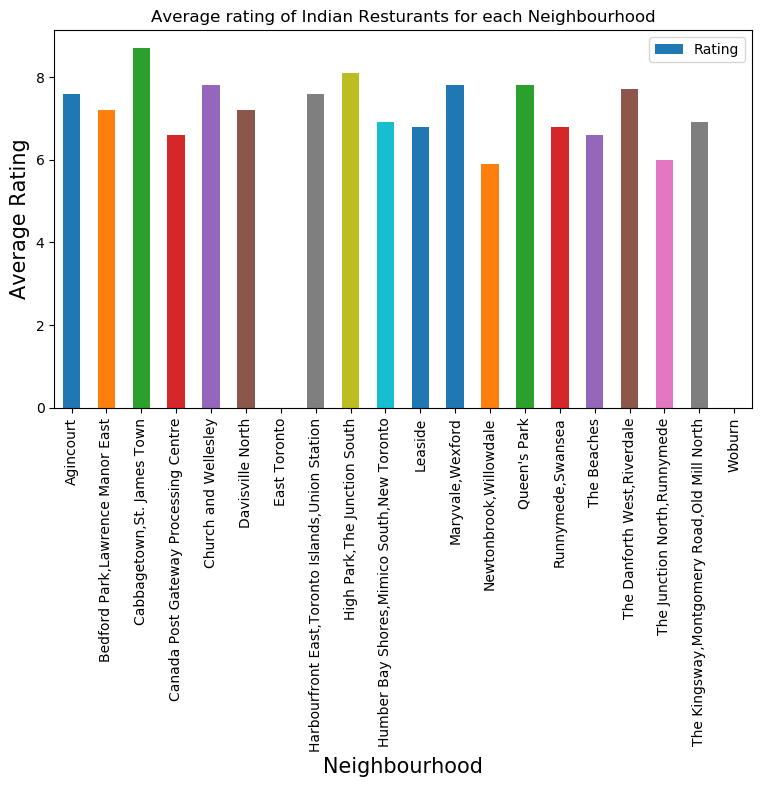

In [91]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Neighbourhood')
#On x-axis
plt.xlabel('Neighbourhood', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_toronto.groupby('Neighbourhood').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From above plot we see that the Neighbourhood 'Cabbagetown,St. James Town' has the Top Average rating among the Neighbourhoods having minimum number of Indian restaurents.